In [1]:
import random
import numpy as np
from skimage import io, util
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
import os
import pickle

# Function to convert mask to y
def mask_to_y(mask):
    return mask.flatten()

# Function to extract patches from the green channel of an image
def image_to_X(image, patch_size=5):
    pad_size = patch_size // 2
    padded = np.pad(image[:, :, 1], (pad_size, pad_size), mode='constant', constant_values=0)
    patches = util.view_as_windows(padded, window_shape=(patch_size, patch_size), step=1)
    return patches.reshape(-1, patch_size*patch_size)

# Parameters
patch_size = 11
sample_percentage = 0.05
image_folder = 'images'
mask_folder = 'manual1'

# Collect image and mask file paths
image_files = sorted([f for f in os.listdir(image_folder) if f.endswith('.jpg')])
mask_files = sorted([f for f in os.listdir(mask_folder) if f.endswith('.tif')])

X_train_list = []
y_train_list = []

selected_indices = random.sample(range(len(image_files)), 5)
selected_image_files = [image_files[i] for i in selected_indices]
# change extension to tif and folder to manual1
selected_mask_files = [f.replace('.jpg', '.tif') for f in selected_image_files]

X_train_list = []
y_train_list = []

# Load and process each pair of selected image and mask files
for image_file, mask_file in zip(selected_image_files, selected_mask_files):
    image_path = os.path.join(image_folder, image_file)
    mask_path = os.path.join(mask_folder, mask_file)

    fundus = io.imread(image_path)
    mask = io.imread(mask_path, as_gray=True).astype(np.uint8)

    y_train_list.append(mask_to_y(mask))
    X_train_list.append(image_to_X(fundus, patch_size))


# Concatenate all image patches and mask labels
X_train = np.vstack(X_train_list)
y_train = np.concatenate(y_train_list)

# Select a subsample - 5% of all examples + undersampling
n_train = X_train.shape[0]
sub = np.random.choice(n_train, int(sample_percentage * n_train), replace=False)
rus = RandomUnderSampler(random_state=42)
X_under, y_under = rus.fit_resample(X_train[sub], y_train[sub])

# Train the model
model = RandomForestClassifier(n_estimators=200, n_jobs=-1)
model.fit(X_under, y_under)

# Save the trained model
with open('model-green.pkl', 'wb') as f:
    pickle.dump(model, f)




In [2]:
model

RandomForestClassifier(n_estimators=200, n_jobs=-1)

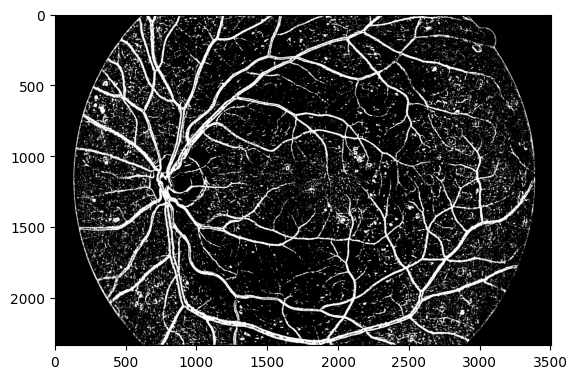

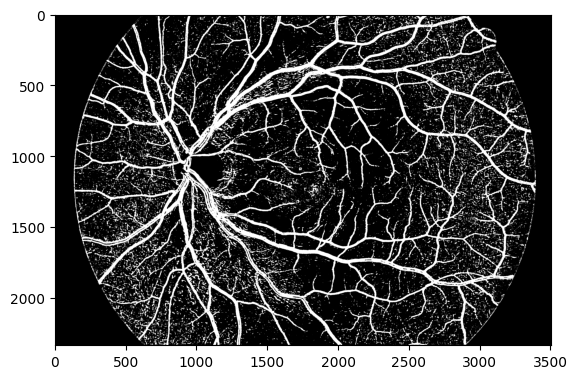

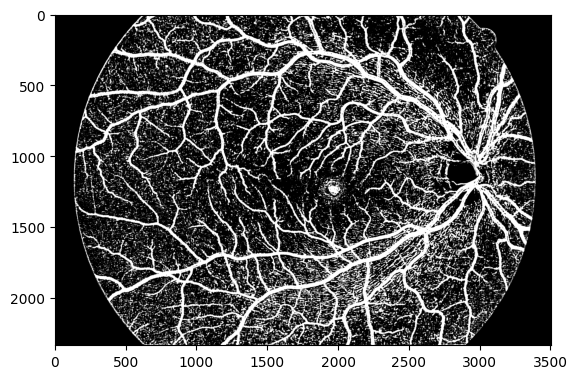

In [4]:
# Test model
test_1 = io.imread('images/01_dr.jpg')
test_2 = io.imread('images/02_h.jpg')
test_3 = io.imread('images/11_h.jpg')

X_test_1 = image_to_X(test_1, patch_size)
X_test_2 = image_to_X(test_2, patch_size)
X_test_3 = image_to_X(test_3, patch_size)

y_pred_1 = model.predict(X_test_1)
y_pred_2 = model.predict(X_test_2)
y_pred_3 = model.predict(X_test_3)

y_pred_1 = y_pred_1.reshape(test_1.shape[0], test_1.shape[1])
y_pred_2 = y_pred_2.reshape(test_2.shape[0], test_2.shape[1])
y_pred_3 = y_pred_3.reshape(test_3.shape[0], test_3.shape[1])

# show it plt
import matplotlib.pyplot as plt
plt.imshow(y_pred_1, cmap='gray')
plt.show()
plt.imshow(y_pred_2, cmap='gray')
plt.show()
plt.imshow(y_pred_3, cmap='gray')
plt.show()

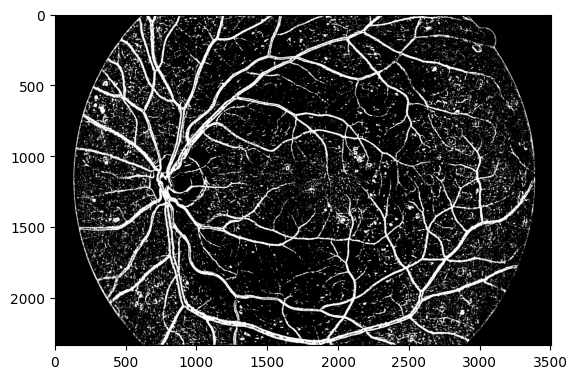

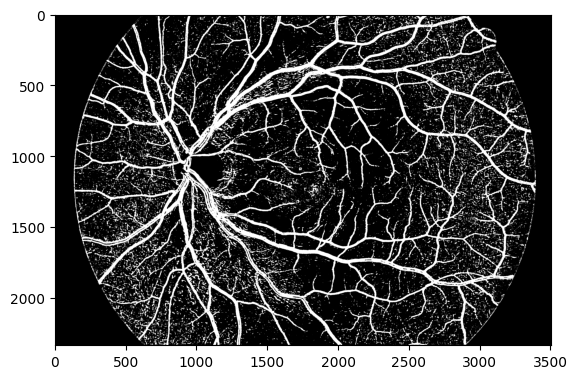

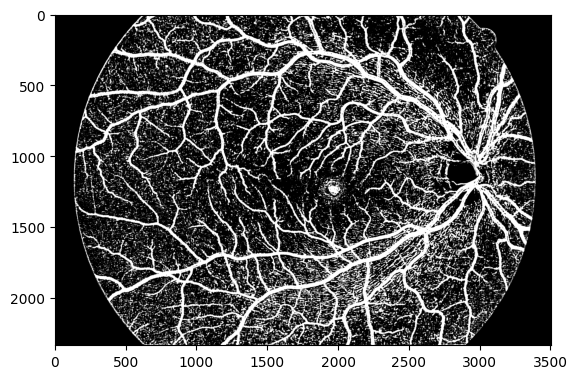

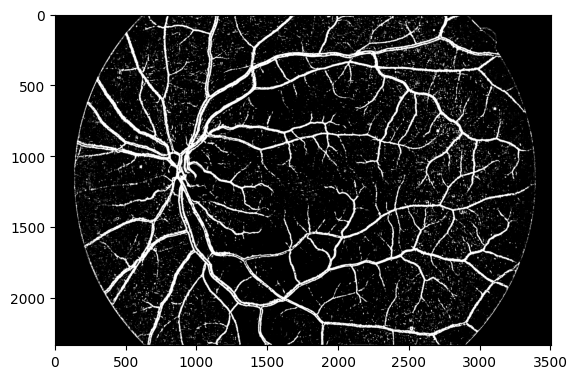

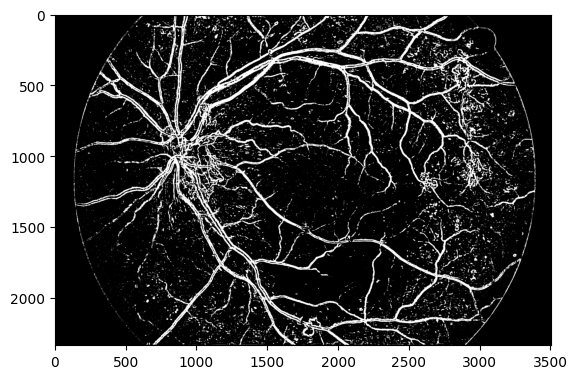

In [5]:
test_4 = io.imread('images/09_g.jpg')
test_5 = io.imread('images/12_dr.jpg')

X_test_4 = image_to_X(test_4, patch_size)
X_test_5 = image_to_X(test_5, patch_size)

y_pred_4 = model.predict(X_test_4)
y_pred_5 = model.predict(X_test_5)


y_pred_4 = y_pred_4.reshape(test_4.shape[0], test_4.shape[1])
y_pred_5 = y_pred_5.reshape(test_5.shape[0], test_5.shape[1])

plt.imshow(y_pred_1, cmap='gray')
plt.show()
plt.imshow(y_pred_2, cmap='gray')
plt.show()
plt.imshow(y_pred_3, cmap='gray')
plt.show()
plt.imshow(y_pred_4, cmap='gray')
plt.show()
plt.imshow(y_pred_5, cmap='gray')
plt.show()

In [19]:
import cv2

cv2.imwrite("y_pred_1.png", y_pred_1)
cv2.imwrite("y_pred_2.png", y_pred_2)
cv2.imwrite("y_pred_3.png", y_pred_3)
cv2.imwrite("y_pred_4.png", y_pred_4)
cv2.imwrite("y_pred_5.png", y_pred_5)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
additional_mask_folder = 'mask'

test_files = ['01_dr.jpg', '02_h.jpg', '11_h.jpg', '09_g.jpg', '12_dr.jpg']
test_images = [io.imread(os.path.join(image_folder, f)) for f in test_files]
test_masks = [io.imread(os.path.join(mask_folder, f.replace('.jpg', '.tif')), as_gray=True).astype(np.uint8) for f in test_files]

X_tests = [image_to_X(img, patch_size) for img in test_images]
y_tests = [mask_to_y(mask) for mask in test_masks]

y_preds = [model.predict(X_test) for X_test in X_tests]
y_preds_reshaped = [y_pred.reshape(img.shape[0], img.shape[1]) for y_pred, img in zip(y_preds, test_images)]

# Save predicted images
for i, y_pred in enumerate(y_preds_reshaped):
    cv2.imwrite(f"y_pred_{i+1}.png", (y_pred * 255).astype(np.uint8))

# Calculate and display confusion matrices using additional masks
for i, (image_file, y_test, y_pred) in enumerate(zip(test_files, y_tests, y_preds)):
    mask_path = os.path.join(additional_mask_folder, image_file.replace('.jpg', '_mask.tif'))
    additional_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Resize mask to match the size of the predicted images
    resized_shape = y_pred.reshape(y_preds_reshaped[0].shape).shape  # use shape of predicted images
    additional_mask_resized = cv2.resize(additional_mask, (resized_shape[1], resized_shape[0]))

    threshold = 127
    correct_mask = additional_mask_resized > threshold
    pred_mask = y_pred.reshape(resized_shape[0], resized_shape[1]) > 0

    # Calculate confusion matrix manually
    true_positive = np.sum((correct_mask == True) & (pred_mask == True))
    false_positive = np.sum((correct_mask == False) & (pred_mask == True))
    false_negative = np.sum((correct_mask == True) & (pred_mask == False))
    true_negative = np.sum((correct_mask == False) & (pred_mask == False))

    print(f"True Positive for test image {i+1}: {true_positive}")
    print(f"False Positive for test image {i+1}: {false_positive}")
    print(f"False Negative for test image {i+1}: {false_negative}")
    print(f"True Negative for test image {i+1}: {true_negative}")

    # Display confusion matrix as a plot
    manual_cm = np.array([[true_positive, false_negative],
                          [false_positive, true_negative]])

    disp_manual = ConfusionMatrixDisplay(confusion_matrix=manual_cm, display_labels=['Positive', 'Negative'])
    disp_manual.plot(cmap='viridis')
    plt.title(f'Manual Confusion Matrix for test image {i+1}')
    plt.show()

## Uczenie maszynowe krok po kroku
1. Wczytaj obrazy i maski z folderów `images` i `manual1`.
2. Dla każdej pary obraz-maskę:
    1. Przekształć obraz na macierz `X` zawierającą patche o rozmiarze `patch_size`.
    2. Przekształć maskę na wektor `y`.
3. Połącz wszystkie macierze `X` i wektory `y` w jedną macierz `X_train` i wektor `y_train`.
4. Wybierz losowo 5% przykładów z `X_train` i `y_train`.
5. Zastosuj undersampling do wybranych przykładów.
6. Wytrenuj model `RandomForestClassifier` z 200 drzewami.
7. Zapisz wytrenowany model do pliku `model-green.pkl`.